## <center> Рестораны Burger King - ранжирование по количеству конкурентов (KFC) в Москве

In [1]:
import re

from bs4 import BeautifulSoup
from geopy.distance import distance
from ipyleaflet import Map, basemaps, Circle, LegendControl, LayerGroup, Popup
from IPython.display import display
from ipywidgets import HTML
import numpy as np
import pandas as pd
import requests
import seaborn as sns

**Получим координаты ресторанов Burger King**  
  
Из скачанного JSON сохраним только столбцы 'storeId', 'latitude' и 'longitude'.

In [3]:
url = 'https://burgerking.ru/restaurant-locations-json-reply-new/'
r = requests.get(url)
html = r.content
soup = BeautifulSoup(html,'html.parser')
df_bk = pd.read_json(str(soup.encode('utf-8')).lstrip("b'").rstrip("'"), orient='records')[['storeId', 'latitude', 'longitude']]
df_bk.describe()

,storeId,latitude,longitude
count,752.000000,752.000000,752.000000
mean,509.002660,55.391408,44.262277
std,250.943954,3.784405,14.779865
min,1.000000,43.113688,29.078199
25%,317.750000,54.986900,37.457047
50%,523.500000,55.750378,37.840324
75%,724.250000,56.629225,48.571676
max,915.000000,68.967102,131.951319


**Как можно заметить из значений широты и долготы, кроме московских ресторанов были получены все отсальные рестораны на территории России. Оставим только рестораны, находящиеся в Москве.**

In [4]:
# Сократим пространство для поиска, указав грубые границы Москвы
min_lat, max_lat, min_lon, max_lon = [54.5, 56.5, 36.5, 38.5]
df_bk = df_bk[(df_bk['latitude'] > min_lat)
              & (df_bk['latitude'] < max_lat)
              & (df_bk['longitude'] > min_lon)
              & (df_bk['longitude'] < max_lon)]

# По уже изветным ID сделаем серию запросов и найдем все московские рестораны 
def get_moscow_bk(x):
    url = 'https://burgerking.ru/map-markers-info?storeId=' + str(x) + '&lat=&lon='
    r = requests.get(url)
    soup = BeautifulSoup(r.content,'html.parser')
    city = str(soup.find("p", class_="over-bubble-city").string)
    if city == 'Москва':
        return True
    else:
        return False

df_bk['default_city'] = df_bk['storeId'].apply(lambda x: get_moscow_bk(x))
df_bk = df_bk[df_bk['default_city']][['latitude', 'longitude']]
df_bk.describe()

,latitude,longitude
count,176.000000,176.000000
mean,55.731538,37.599008
std,0.088697,0.118417
min,55.524426,37.286292
25%,55.658817,37.517396
50%,55.739583,37.603735
75%,55.795755,37.662569
max,55.939877,37.931641


**Теперь получим список координат московских ресторанов KFC**

In [5]:
url = 'https://www.kfc.ru/restaurants'

r = requests.get(url)
html = r.text
pattern = re.compile('(?<=restaurantsList":).*(?=,"mappedRestaurantsList)')
match = re.search(pattern, html)
if match:
    s_kfc = pd.read_json(match.group(), orient='records', encoding='windows-1251')
else:
    print('Список ресторанов restaurantsList не найден!')

    
def search_coords(x):
    pattern = re.compile(r'(?<=coordinates":)(\[.*\])(?=\})')
    match = re.search(pattern, str(x))
    if match:
        x = match.group()
    else:
        x = np.nan
    return x

Moscow_CityId = '7575f6fe-1cc8-4e95-a63e-cb7008868fde'
s_kfc = s_kfc[s_kfc['kfcCityId'] == Moscow_CityId]['contacts'].apply(lambda x: x['coordinates']['geometry']['coordinates'])
s_kfc.head()

0    [55.775006, 37.583211]
1    [55.770008, 37.596554]
2    [55.779947, 37.600095]
3    [55.761217, 37.576088]
4    [55.764544, 37.564352]
Name: contacts, dtype: object

**Проверим отсутствие пустых записей**

In [6]:
s_kfc.isnull().values.any()

False

**Пустых записей не найдено.  
Найдем для каждого ресторана Burger King рестораны KFC, расположенные в радиусе 2 км. Координаты ресторанов KFC, удовлетворяющих условию близости.  
Отсортируем рестораны Burger King по количеству конкуренов в радиусе 2 км.**

In [7]:
def nearest_kfc(df_bk, s_kfc):
    counts=[]
    for i in df_bk.index:
        count = 0
        for kfc in s_kfc.values:
            d = distance((float(df_bk['latitude'][[i]]), float(df_bk['longitude'][[i]])), kfc).km
            if d <= 2:
                count += 1
        counts.append(count)
    return counts

df_bk['nearest_kfc'] = pd.Series(nearest_kfc(df_bk, s_kfc), index=df_bk.index)
df_bk.sort_values('nearest_kfc', inplace=True)
df_bk

,latitude,longitude,nearest_kfc
56,55.767115,37.371795,0
70,55.637078,37.353189,0
479,55.625748,37.306488,0
61,55.605058,37.286292,0
652,55.826660,37.444790,0
...,...,...,...
457,55.781134,37.631883,10
503,55.760488,37.614732,10
67,55.752630,37.603551,12
456,55.771794,37.633162,12


**Посмотрим на распределение количества ближайших KFC, чтобы получить дополнительную информацию к выбору цветов маркеров и соответсвующих интервалов интересуемой величины.**

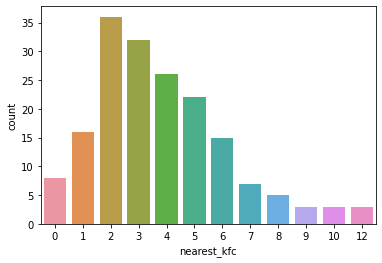

In [8]:
b = sns.countplot(x='nearest_kfc', data=df_bk);

**Все возможные значения nearest_kfc отображать на карте не выглядит удобным для анализа вариантом.
Поэтому выберем диапазоны значений nearest_kfc, в качестве исключения оставив нулевому значению отдельный цвет
и отделив все, что больше 12, в отдельную группу.  
Добавим к df_bk столбец с цветом маркера, отображаемого на карте.**


In [9]:
def set_color(x):
    if x == 0:
        x = '#8A0886'
    elif x in [1, 2]:
        x = 'blue'
    elif x in [3, 4]:
        x = '#04B404'
    elif x in [5, 6, 7]:
        x = 'yellow'
    elif x in [8, 9, 10, 11]:
        x = 'orange'
    elif x >= 12:
        x = 'red'
    return x

df_bk['color'] = df_bk['nearest_kfc'].apply(lambda x: set_color(x))
df_bk

,latitude,longitude,nearest_kfc,color
56,55.767115,37.371795,0,#8A0886
70,55.637078,37.353189,0,#8A0886
479,55.625748,37.306488,0,#8A0886
61,55.605058,37.286292,0,#8A0886
652,55.826660,37.444790,0,#8A0886
...,...,...,...,...
457,55.781134,37.631883,10,orange
503,55.760488,37.614732,10,orange
67,55.752630,37.603551,12,red
456,55.771794,37.633162,12,red


**Отобразим рестораны Burger King на карте Москвы.**

In [10]:
center = (55.775006, 37.583211)
zoom = 10
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)
bk_circles = []
for i in df_bk.index:
    circle = Circle(location=(float(df_bk['latitude'][[i]]), float(df_bk['longitude'][[i]])))
    message = HTML()
    message.value = f"<b>Количество<br>конкурентов:</b> {int(df_bk['nearest_kfc'][[i]])}"
    circle.popup = message
    circle.radius = 5
    circle.color = df_bk['color'][[i]].values[0]
    circle.fill_color = df_bk['color'][[i]].values[0]
    bk_circles.append(circle)
bk_layer = LayerGroup(name='Burger King', layers=bk_circles)
m.add_layer(bk_layer)


legend = LegendControl({"0":"#B404AE", "1-2":"blue",
                        "3-4":"#04B404", "5-7": "yellow",
                        "8-11": "orange", ">=12": "red"}, 
                        name="Кол-во конкурентов", position="topright")
m.add_control(legend)

display(m)

Map(center=[55.775006, 37.583211], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…